# MUSIC GENRE ANALYSIS

Here, We are trying to cluster songs based on keywords i.e. analyze the distribution of genres among similar keywords. We'll go through the following steps:

1. Vectorization of Keywords
2. Dimensionality reduction using PCA
3. Combining the embeddings into one
4. Clustering
5. Final analyisis

Let's start by importing the necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Vectorization of Keywords

Here we are converting the textual data into numerical vectors by using the classical embedding technique Tf-Idf.

(Justification of choice is in report)

In [ ]:
def tfidf(df, keyword_column):
    words = df[keyword_column].unique()
    n_docs = len(df)
    idf = {}
    for word in words:
        n_containing = df[keyword_column].value_counts().get(word)
        idf[word] = np.log(n_docs / n_containing)

    tfidf_vectors = []
    for idx, row in df.iterrows():
        word = row[keyword_column]
        vector = np.zeros(len(words))
        word_idx = np.where(words == word)[0][0]
        vector[word_idx] = idf[word]
        tfidf_vectors.append(vector)

    return pd.DataFrame(tfidf_vectors, columns=words)

## Step 2: Load Data and Apply TF-IDF

We load the dataset and calculate TF-IDF vectors for each keyword column.


In [ ]:
#upload the dataset the same folder as the code
df = pd.read_csv("TASK2_dataset.csv")

tfidf_keyword1 = tfidf(df, 'keyword_1')
tfidf_keyword2 = tfidf(df, 'keyword_2')
tfidf_keyword3 = tfidf(df, 'keyword_3')


## Step 3: Define PCA Class

Next, we define a custom PCA (Principal Component Analysis) class for dimensionality reduction.


In [ ]:
class PCA:
    def __init__(self, n_vectors):
        self.n_vectors = n_vectors
        self.vectors = None
        self.mean = None
        self.X = None

    def fit(self, X):
        self.X = X
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean  # Centering the data

        cov = np.cov(X_centered.T) #Covariance Matrix

        #Calculating Eigenvalues and Eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov)


        idx = np.argsort(eigenvalues)[::-1] #Sorting
        eigenvectors = eigenvectors[:, idx]

        self.vectors = eigenvectors[:, :self.n_vectors]

    def transform(self, X):
        # Center the data
        X_centered = X - self.mean
        return np.dot(X_centered, self.vectors)

     # Calculate the proportion of variance explained by each PC
    def explained_variance_ratio(self):
      #I've used this just to check the variance distributions
        # Calculate the total variance
        total_variance = np.sum(np.var(self.X, axis=0))

        # Calculate the variance explained by each principal component
        X_transformed = self.transform(self.X)
        explained_variance = np.var(X_transformed, axis=0)

        return explained_variance / total_variance


## Step 4: Apply PCA to TF-IDF Vectors

We apply PCA to reduce the dimensionality of our TF-IDF vectors and combine the results by averaging method.

(Justification is provided in report)

In [ ]:
pca1 = PCA(n_vectors=2)
pca1.fit(tfidf_keyword1.values)
keyword1_pca = pca1.transform(tfidf_keyword1.values)

pca2 = PCA(n_vectors=2)
pca2.fit(tfidf_keyword2.values)
keyword2_pca = pca2.transform(tfidf_keyword2.values)

pca3 = PCA(n_vectors=2)
pca3.fit(tfidf_keyword3.values)
keyword3_pca = pca3.transform(tfidf_keyword3.values)

combined_embedding = (keyword1_pca + keyword2_pca + keyword3_pca) / 3


## Step 5: Define K-means Clustering Function

We define a function to perform K-means clustering on our data.


In [ ]:
np.random.seed(0)
#with seed 42 Iam getting worse results and less slihoutte score

def kmeans(X, k, max_iters=1000):
    #Chososing random centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(max_iters):
        dist = np.zeros((k, X.shape[0]))
        for i in range(k):
            #Calclulating distance between each point and centroid
            dist[i] = np.linalg.norm(X - centroids[i], axis=1)
        #Labeling the point with the centroid withe least dist
        labels = np.argmin(dist, axis=0)

        #Storing the new centroids
        new_centroids = np.zeros((k, X.shape[1]))
        for i in range(k):
            cluster_points = X[np.where(labels == i)]
            new_centroids[i] = cluster_points.mean(axis=0)

        if np.linalg.norm(centroids - new_centroids) < 1e-6:
          break
        """Giving same results as np.all(centroid == new_centroids)
           but this is more appropriate break condition"""

        centroids = new_centroids

    return labels, centroids


## Step 6: Determine Optimal Number of Clusters

We use the elbow method to determine the optimal number of clusters for our data.


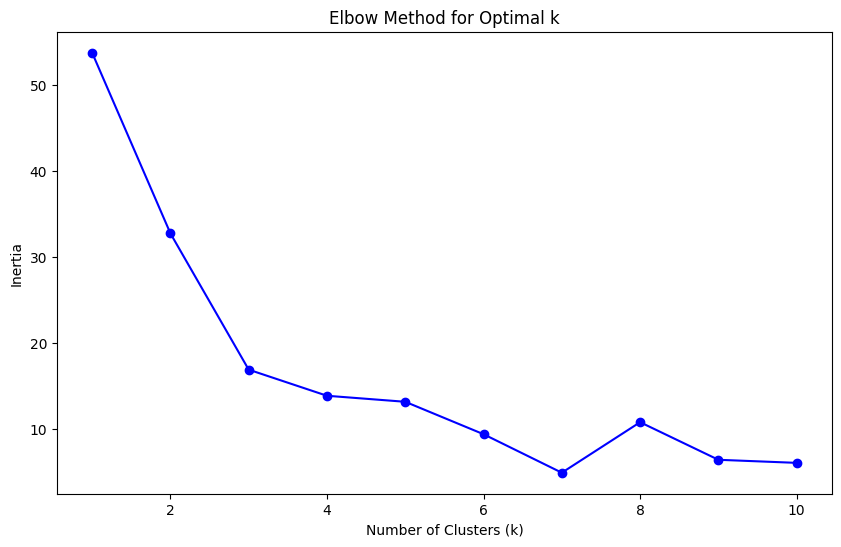

In [ ]:
inertias = []
for k in range(1, 11):
    labels, centroids = kmeans(combined_embedding, k)
    inertia = np.sum((combined_embedding - centroids[labels]) ** 2)
    inertias.append(inertia)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


## Step 7: Apply K-means Clustering and Visualize Results

Based on the elbow curve, we choose the optimal number of clusters which here is 3 and apply K-means clustering.


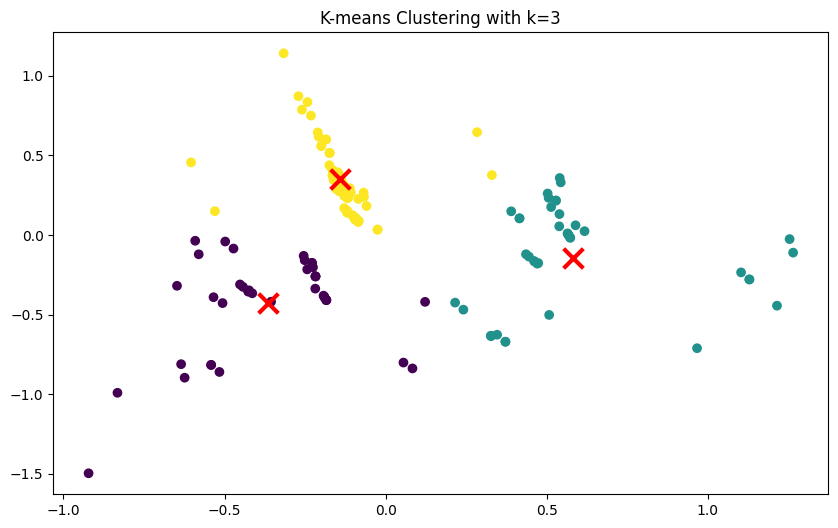

In [ ]:
k = 3
labels, centroids = kmeans(combined_embedding, k)

plt.figure(figsize=(10, 6))
plt.scatter(combined_embedding[:, 0], combined_embedding[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.title(f'K-means Clustering with k={k}')
plt.show()


## Step 8: Analyze Cluster Composition

Finally, we analyze the composition of each cluster in terms of music genres.


Genre Distribution Across Clusters:
Cluster  genre    
0        classical    30.000000
         country      20.000000
         hip-hop      20.000000
         pop          17.500000
         rock         12.500000
1        hip-hop      24.390244
         rock         24.390244
         country      21.951220
         classical    14.634146
         pop          14.634146
2        pop          27.272727
         rock         22.727273
         country      18.181818
         hip-hop      18.181818
         classical    13.636364
Name: proportion, dtype: float64


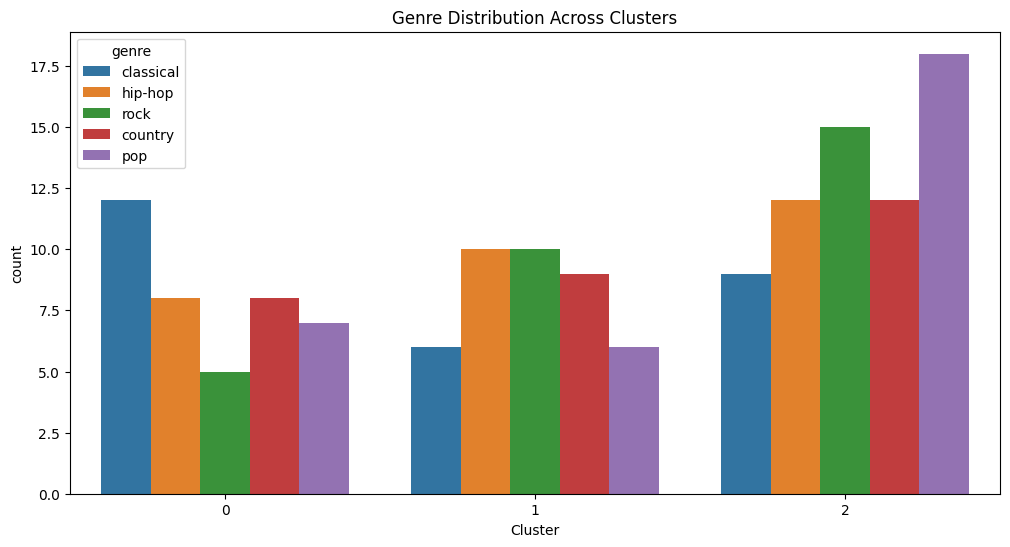

In [ ]:
df['Cluster'] = labels

genre_distribution = df.groupby('Cluster')['genre'].value_counts(normalize=True) * 100
print("Genre Distribution Across Clusters:")
print(genre_distribution)

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Cluster', hue='genre')
plt.title('Genre Distribution Across Clusters')
plt.show()


#Step 9: Silhouette Score
We can see the distribution of genres in each class as printed in the output above.

In cluster 1 we can see that Classic genre is dominant which has 30% weight.
In cluster 2 we can see that there are mix of genres such as hip hop and rock this may be due to similar key words associated with these genres.
In cluster 3 we can see the pop genre is dominant which has 27% weight which is followed by rock genre with 222% weight again due to similar keywords.

Now we need to see how well the cluster is formed, we can do this by calculating Silhouette score of the clustering which is implemented as follows.

In [ ]:
def silhouette_score(X, labels,k):
    n_samples = X.shape[0]
    n_clusters = k

    # pairwise distances are calculated while broadcasting
    diff = X[:, np.newaxis] - X[np.newaxis, :]
    distances = np.linalg.norm(diff, axis=2)

    # Calculate a (mean intra-cluster distance) - cohesion
    a = np.zeros(n_samples)
    for i in range(n_samples):
        same_label = (labels == labels[i])  # Find points with the same label as point i
        a[i] = np.mean(distances[i][same_label])

    # Calculate b (mean nearest-cluster distance) - separation
    b = np.zeros(n_samples)
    for i in range(n_samples):
        # Calculate mean distances to each cluster (excluding the point's own cluster)
        mean_distances = [np.mean(distances[i][labels == j]) for j in range(n_clusters) if j != labels[i]]
        # mini of these mean_distances
        b[i] = np.min(mean_distances)

    # Calculate silhouette scores
    s = (b - a) / np.maximum(a, b)

    return np.mean(s)


# Calculate Silhouette Score
silhouette_avg = silhouette_score(combined_embedding, labels,k)
print(f"The average Silhouette Score is: {silhouette_avg}")

The average Silhouette Score is: 0.5406517063758718


#Step 10: Assigning genres to new songs:
As we can the the silhouette is around 0.541 which is a quite reasonable clustering.

Now finally we want to assign genres to new songs based on keywords with the help of analysis done till now.

Since we have already done the analysis we can simply calculate the embedding of new song and see which is nearest to it in the combined_emedding and assign it the same genre.

In [ ]:
def assign_genre(keywords, n=5):
    #Creating new data frame for given key words
    new_df = pd.concat([df['keyword_1'], df['keyword_2'], df['keyword_3']]).unique()
    unique_keywords = pd.DataFrame({'keyword': new_df})

    # Calculate TF-IDF for each input keyword
    new_tfidf = []
    for kw in keywords:
        combined_keywords = pd.concat([unique_keywords, pd.DataFrame({'keyword': [kw]})])
        new = tfidf(combined_keywords, 'keyword').iloc[-1:]
        new_tfidf.append(new)

    # Reindexing the new tfidf vectors so that we will not have any shape problems when we do pca
    new_tfidf[0] = new_tfidf[0].reindex(columns=tfidf_keyword1.columns, fill_value=0)
    new_tfidf[1] = new_tfidf[1].reindex(columns=tfidf_keyword2.columns, fill_value=0)
    new_tfidf[2] = new_tfidf[2].reindex(columns=tfidf_keyword3.columns, fill_value=0)

    # Apply PCA to reduce dimensionality
    n1 = pca1.transform(new_tfidf[0].values)
    n2 = pca2.transform(new_tfidf[1].values)
    n3 = pca3.transform(new_tfidf[2].values)


    # Average the PCA vectors to get a combined embedding
    new_embedding = (n1+n2+n3)/3

    # Calculate distances and find nearest neighbors
    distances = np.linalg.norm(combined_embedding - new_embedding, axis=1)
    nearest_indices = np.argsort(distances)[:n]

    # Return the most common genre among the nearest neighbors
    return df.loc[nearest_indices, 'genre'].mode()[0]


new_songs = [
    ['piano', 'calm', 'slow'],
    ['guitar', 'emotional', 'distorted'],
    ['synth', 'mellow', 'distorted']
]

for song in new_songs:
    predicted_genre = assign_genre(song)
    print(f"for the Keywords: {song} the Predicted Genre is : {predicted_genre}")


for the Keywords: ['piano', 'calm', 'slow'] the Predicted Genre is : classical
for the Keywords: ['guitar', 'emotional', 'distorted'] the Predicted Genre is : rock
for the Keywords: ['synth', 'mellow', 'distorted'] the Predicted Genre is : hip-hop


As we can see the model is predicting the genre of new song quite correctly.

We have to noticethat we dont require pca.fit() again becuase we have already fitted it on the training data so only transform is enough